In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3"

from fastai.imports import *
from fastai.conv_learner import *
from fastai.plots import *

torch.cuda.is_available()
torch.backends.cudnn.enabled
torch.cuda.device_count()
torch.cuda.get_device_name(2)
torch.cuda.set_device(0)
torch.cuda.current_device()

import warnings
warnings.simplefilter("ignore", UserWarning,)

PATH = '/root/data/sar_cars/'

In [2]:
train = glob(os.path.join(PATH, 'train', '*.png'))
label_csv = f'{PATH}labels_balanced.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [3]:
bs = 16
f_model = resnet34()

In [4]:
def get_data(sz,bs=64):    
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    #tfms = tfms_from_model(f_model, sz, aug_tfms=None, max_zoom=None)
    #tfms = tfms_from_model(f_model, sz, pad_mode=0, crop_type=CropType.NO)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                    suffix='.png', val_idxs=val_idxs, bs=bs)

In [5]:
data = get_data(64,bs)

torch.Size([16, 3, 64, 64]) torch.Size([16])
['Chevrolet_HHR_LT', 'Chevrolet_Impala_LT', 'Chrysler_Town_&_Country', 'Mitsubishi_Galant_ES', 'Pontiac_Torrent', 'Toyota_Highlander']


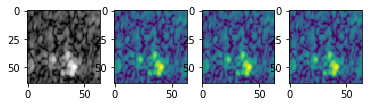

In [6]:
x,y = next(iter(data.val_dl))

print(x.shape, y.shape)
print(data.classes)

f, (ax0,ax1,ax2,ax3) = plt.subplots(1,4)
ax0.imshow(data.trn_ds.denorm(x)[0]) # b/w (3-c)
ax1.imshow(x[0][0]) # three individual channels
ax2.imshow(x[0][1]) 
ax3.imshow(x[0][2])
plt.show();

In [7]:
img = PIL.Image.open(train[1])
img_np = np.array(img)
img_np[:3,:3,0]
img_np[:3,:3,1]
img_np[:3,:3,2]

x[1,:,:2,:2]

#print(np.allclose(x[0][0], x[0][1])); # not equal (ideally would just duplicate single channel)

array([[14,  6, 22],
       [44, 38, 41],
       [59, 54, 53]], dtype=uint8)

array([[14,  6, 22],
       [44, 38, 41],
       [59, 54, 53]], dtype=uint8)

array([[14,  6, 22],
       [44, 38, 41],
       [59, 54, 53]], dtype=uint8)

tensor([[[ 0.1165, -0.1917],
         [ 0.3700,  0.0343]],

        [[ 0.2486, -0.0665],
         [ 0.5077,  0.1646]],

        [[ 0.4697,  0.1560],
         [ 0.7277,  0.3861]]], device='cuda:0')

In [8]:
# Uncomment the below if you need to reset your precomputed activations
#shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

m = f_model
bm = BasicModel(m.cuda(), )
learn = ConvLearner(data, bm)

64

In [9]:
lrf=learn.lr_find()
learn.sched.plot()

  0%|          | 0/2078 [00:00<?, ?it/s]


RuntimeError: Given input size: (512x2x2). Calculated output size: (512x-4x-4). Output size is too small at /opt/conda/conda-bld/pytorch_1525909934016/work/aten/src/THCUNN/generic/SpatialAveragePooling.cu:63

In [ ]:
#%time learn.fit(1e-5, 10, cycle_len=1, cycle_mult=1)
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()
learn.save('res_pre')

In [ ]:
learn = ConvLearner.pretrained(f_model, data, precompute=True)
learn.load('res_pre')
lrf=learn.lr_find()
learn.sched.plot()

In [ ]:
%time 
lr = 3e-4
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()
learn.save('res_120')

In [ ]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()
learn.save('res_120_2')
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()
learn.save('res_120_3')
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()
learn.save('res_120_4')
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()
learn.save('res_120_5')

In [ ]:
learn = ConvLearner.pretrained(f_model, data, precompute=False)
learn.unfreeze()
learn.load('res_120_5')
learn.set_data(get_data(140))
lrf=learn.lr_find()
learn.sched.plot()

In [ ]:
lr = 1e-3
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()
learn.save('res_140')

In [ ]:
learn = ConvLearner.pretrained(f_model, data, precompute=False)
learn.unfreeze()
learn.load('res_140')
learn.set_data(get_data(140))
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()
learn.save('res_160')